# ENSE 885AY Assignment 3: Camera Calibration and Fundamental Matrix Estimation with RANSAC


(1) Camera Projection Matrix  
(2) Fundamental Matrix Estimation  
(3) Fundamental Matrix with RANSAC  

## Setup

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import student_code as sc

## Part 1: Camera Projection Matrix

In [2]:
# Load the data
points_2d = np.loadtxt('../data/pts2d-norm-pic_a.txt')
points_3d = np.loadtxt('../data/pts3d-norm.txt')

# (Optional) Uncomment these four lines once you have your code working with the easier, normalized points above.
# points_2d = np.loadtxt('../data/pts2d-norm-pic_b.txt')
# points_3d = np.loadtxt('../data/pts3d.txt')

### Calculate the projection matrix given corresponding 2D & 3D points

The projection matrix is
 [[ 0.76785834 -0.49384797 -0.02339781  0.00674445]
 [-0.0852134  -0.09146818 -0.90652332 -0.08775678]
 [ 0.18265016  0.29882917 -0.07419242  1.        ]]
The total residual is 0.044535


<IPython.core.display.Javascript object>


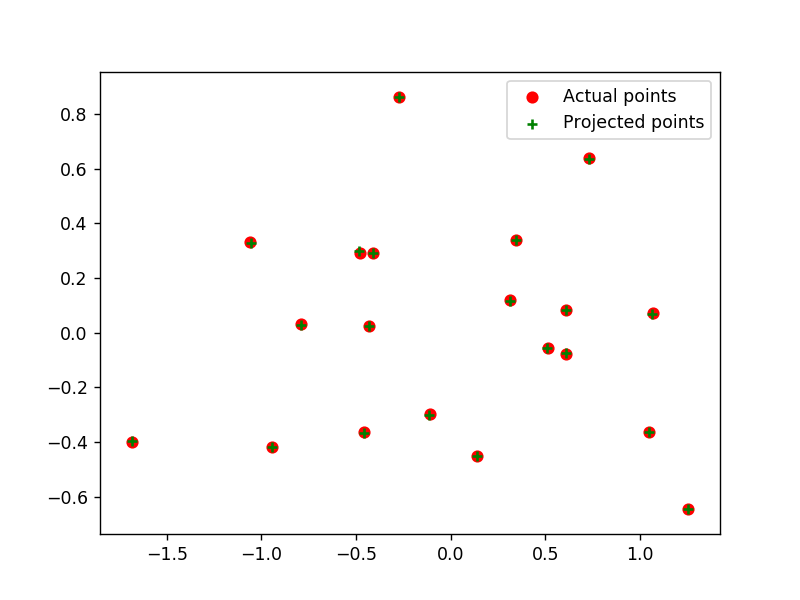

In [3]:
M = sc.calculate_projection_matrix(points_2d, points_3d)
print('The projection matrix is\n', M)

[projected_2d_pts, residual] = evaluate_points(M, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
visualize_points(points_2d, projected_2d_pts)

### Calculate the camera center using M found from the previous step

The estimated location of the camera is <-1.5126, -2.3517, 0.2827>


<IPython.core.display.Javascript object>


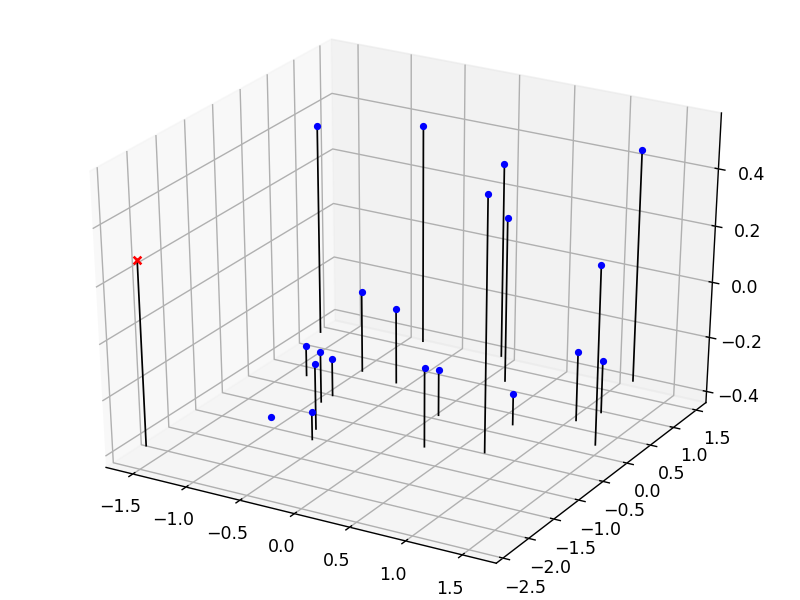

In [4]:
center = sc.calculate_camera_center(M);
print('The estimated location of the camera is <{:.4f}, {:.4f}, {:.4f}>'.format(*center))
plot3dview(points_3d, center)

## Part 2: Fundamental Matrix Estimation

In [10]:
# Load the data
points_2d_pic_a = np.loadtxt('../data/pts2d-pic_a.txt')
points_2d_pic_b = np.loadtxt('../data/pts2d-pic_b.txt')
img_left = load_image('../data/pic_a.jpg')
img_right = load_image('../data/pic_b.jpg')

### Estimate fundamental matrix

F matrix:
 [[-1.17248591e-07  1.60824663e-06 -4.01980786e-04]
 [ 1.11212887e-06 -2.73443755e-07  3.23319884e-03]
 [-2.36400817e-05 -4.44404958e-03  1.03455561e-01]]


<IPython.core.display.Javascript object>


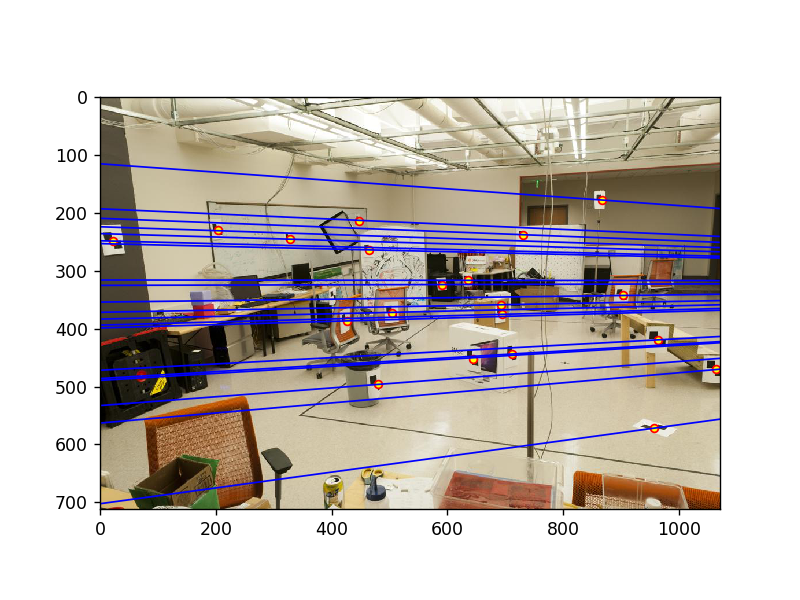

<IPython.core.display.Javascript object>


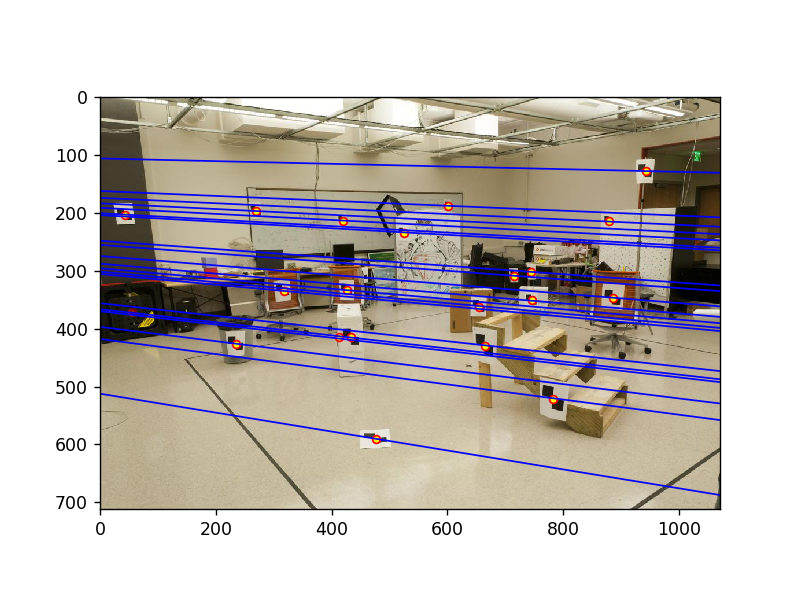

In [11]:
F = sc.estimate_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(F, img_left, img_right, points_2d_pic_a, points_2d_pic_b)

## Part 3: Fundamental Matrix with RANSAC (Szeliski 6.1.4)

**Mount Rushmore**: This pair is easy, and most of the initial matches are correct. The base fundamental matrix estimation without coordinate normalization will work fine with RANSAC. 

**Notre Dame**: This pair is difficult because the keypoints are largely on the same plane. Still, even an inaccurate fundamental matrix can do a pretty good job of filtering spurious matches.  

**Gaudi**: This pair is difficult and doesn't find many correct matches unless you run at high resolution, but that will lead to tens of thousands of ORB features, which will be somewhat slow to process. Normalizing the coordinates seems to make this pair work much better.  

**Woodruff**: This pair has a clearer relationship between the cameras (they are converging and have a wide baseline between them). The estimated fundamental matrix is less ambiguous and you should get epipolar liens qualitatively similar to part 2 of the project.

In [2]:
# Load the data
# Mount Rushmore
# pic_a = load_image('../data/Mount Rushmore/9193029855_2c85a50e91_o.jpg'); scale_a = 0.25
# pic_b = load_image('../data/Mount Rushmore/7433804322_06c5620f13_o.jpg'); scale_b = 0.37
# n_feat = 5e4

# Notre Dame
pic_a = load_image('../data/Notre Dame/921919841_a30df938f2_o.jpg'); scale_a = 0.5
pic_b = load_image('../data/Notre Dame/4191453057_c86028ce1f_o.jpg'); scale_b = 0.5
n_feat = 8e3

# Gaudi
# pic_a = load_image('../data/Episcopal Gaudi/3743214471_1b5bbfda98_o.jpg'); scale_a = 0.8
# pic_b = load_image('../data/Episcopal Gaudi/4386465943_8cf9776378_o.jpg'); scale_b = 1.0
# n_feat = 2e4

# Woodruff
# pic_a = load_image('../data/Woodruff Dorm/wood1.jpg'); scale_a = 0.65
# pic_b = load_image('../data/Woodruff Dorm/wood2.jpg'); scale_b = 0.65
# n_feat = 5e4

pic_a = cv2.resize(pic_a, None, fx=scale_a, fy=scale_a)
pic_b = cv2.resize(pic_b, None, fx=scale_b, fy=scale_b)

Found 1282 possibly matching features


<IPython.core.display.Javascript object>


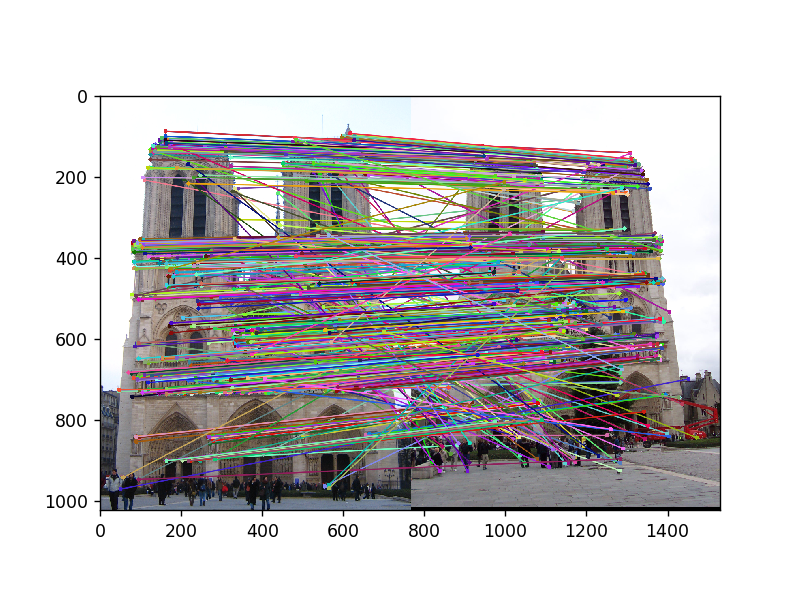

In [3]:
# Finds matching points in the two images using OpenCV's implementation of ORB.
# There can still be many spurious matches, though.
points_2d_pic_a, points_2d_pic_b = get_matches(pic_a, pic_b, n_feat)
print('Found {:d} possibly matching features'.format(len(points_2d_pic_a)))
match_image = show_correspondence2(pic_a, pic_b,
                                   points_2d_pic_a[:, 0], points_2d_pic_a[:, 1],
                                   points_2d_pic_b[:, 0], points_2d_pic_b[:, 1])
plt.figure(); plt.imshow(match_image)

### Calculate the Fundamental Matrix using RANSAC

Found 1048 inliers /  1282 points
inliers / total points : 81 %


<IPython.core.display.Javascript object>


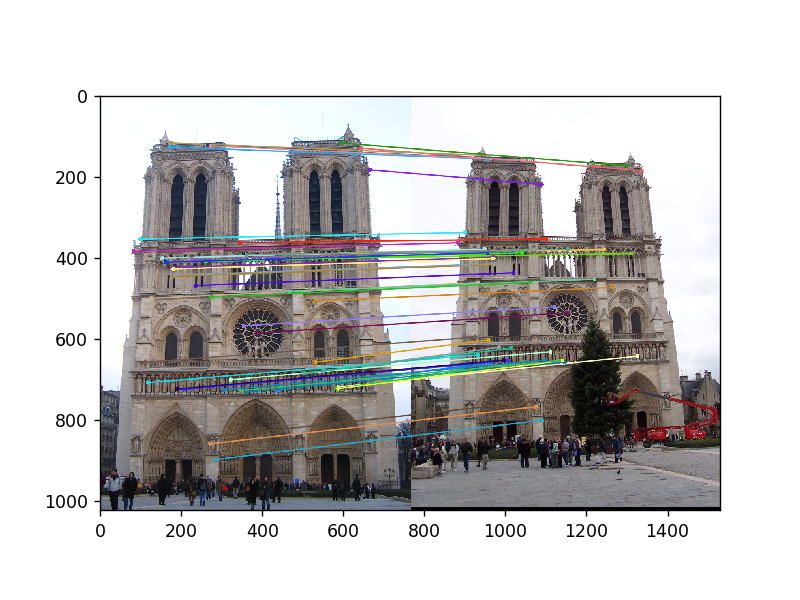

<IPython.core.display.Javascript object>


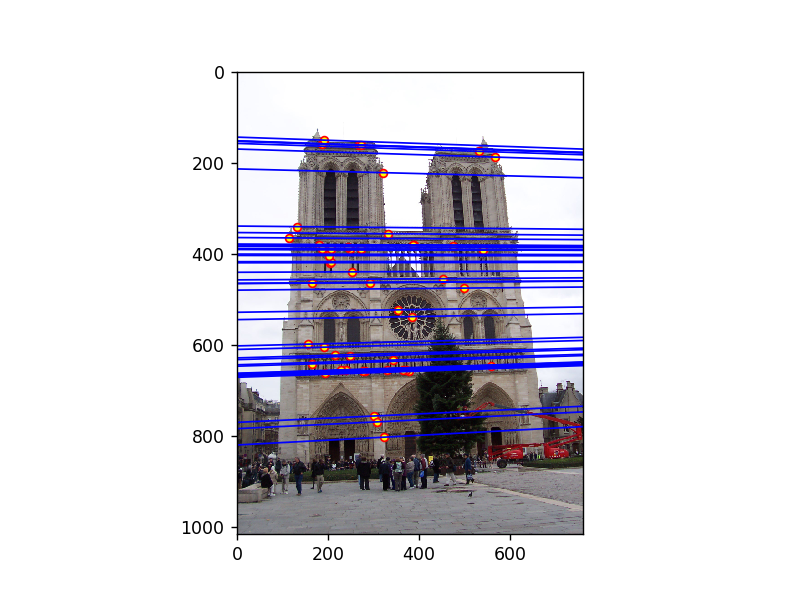

<IPython.core.display.Javascript object>


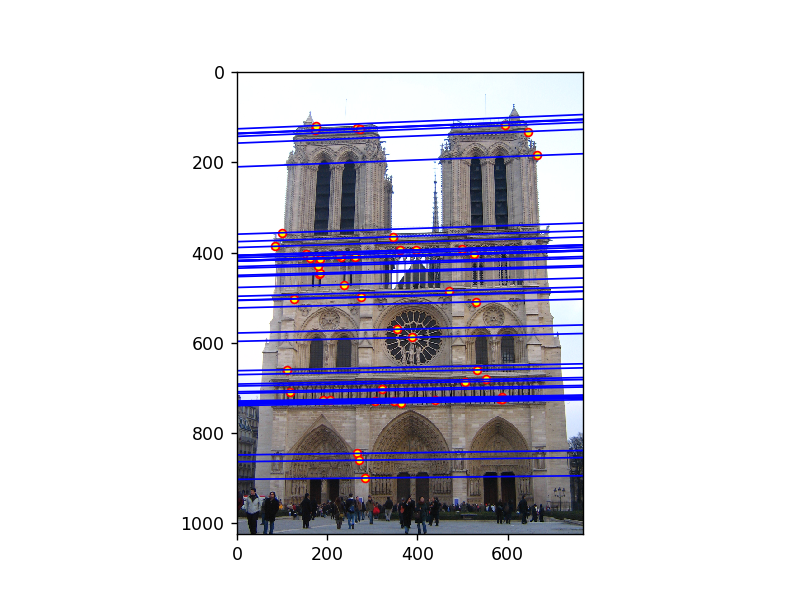

In [4]:
F, matched_points_a, matched_points_b = sc.ransac_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

# Draw the epipolar lines on the images and corresponding matches
match_image = show_correspondence2(pic_a, pic_b,
                                   matched_points_a[:, 0], matched_points_a[:, 1],
                                   matched_points_b[:, 0], matched_points_b[:, 1])
plt.figure(); plt.imshow(match_image)
draw_epipolar_lines(F, pic_a, pic_b, matched_points_a, matched_points_b)

### Tune Threshold

<IPython.core.display.Javascript object>


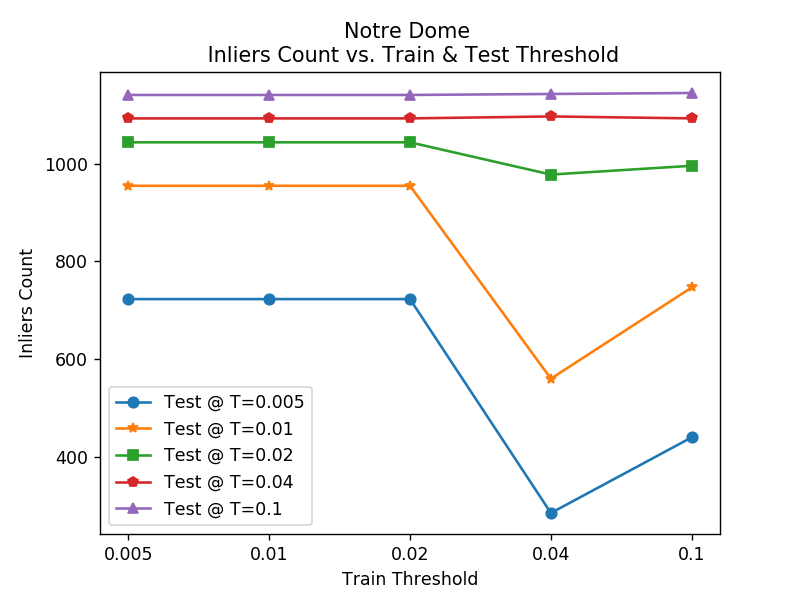

In [5]:
best_inlier_count = sc.tune_ransac_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

# Plot
bic=np.copy(best_inlier_count)

plt.figure()
plt.title("Notre Dome \n Inliers Count vs. Train & Test Threshold")
plt.xlabel("Train Threshold")
plt.ylabel("Inliers Count")
plt.plot(range(5), bic[0,:], '-o', label='Test @ T=0.005')
plt.plot(range(5), bic[1,:], '-*', label='Test @ T=0.01')
plt.plot(range(5), bic[2,:], '-s', label='Test @ T=0.02')
plt.plot(range(5), bic[3,:], '-p', label='Test @ T=0.04')
plt.plot(range(5), bic[4,:], '-^', label='Test @ T=0.1')
plt.xticks(range(5),[0.005, 0.01, 0.02, 0.04, 0.1])
plt.legend()
plt.savefig("100.png", bbox_inches = "tight", dpi=300)
plt.show()